In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import torch 
import torch.nn as nn
import torchvision
import torch.utils.data as Data
import math

import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 全局配置

In [2]:
base_dir = r"E:\Raven\jupyter\DAN\wpt_1024"
batch_size = 64
epochs = 50
source = '0HP'
target = '2HP'

# 工具配置及加载数据

## MMD距离

In [3]:
def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    n_samples = int(source.size()[0])+int(target.size()[0])
    total = torch.cat([source, target], dim=0)
    total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    L2_distance = ((total0-total1)**2).sum(2)
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    return sum(kernel_val)  # /len(kernel_val)


def mmd_rbf_accelerate(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    batch_size = int(source.size()[0])
    kernels = guassian_kernel(source, target,
        kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    loss = 0
    for i in range(batch_size):
        s1, s2 = i, (i+1) % batch_size
        t1, t2 = s1+batch_size, s2+batch_size
        loss += kernels[s1, s2] + kernels[t1, t2]
        loss -= kernels[s1, t2] + kernels[s2, t1]
    return loss / float(batch_size)


def mmd_rbf_noaccelerate(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    batch_size = int(source.size()[0])
    kernels = guassian_kernel(source, target,
                              kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]
    loss = torch.mean(XX + YY - XY -YX)
    return loss

## 加载源域和目标域的数据

In [23]:
from os.path import join
import scipy.io as scio
import random


def load_data(root_path, dir, batch_size):
    data = scio.loadmat(join(root_path, dir, "all_data.mat"))
    label = scio.loadmat(join(root_path, dir, "all_label.mat"))
    label = label.get('label')
    data = data.get('feature')
    permutation = np.random.permutation(data.shape[0])
    # 利用np.random.permutaion函数，获得打乱后的行数，输出permutation
    data = data[permutation]                             # 得到打乱后数据data
    label = label[permutation]                             # 得到打乱后数据label
    
    # 转为tensor
    data = torch.tensor(data)
    
    temp = torch.zeros((1000, 224, 224))
    for i in range(len(data)):
        temp[i] = data[i].repeat(7, 7)
    
    data = temp
    label = torch.tensor(label)
    data = data.to(torch.float32)
    
    data = torch.unsqueeze(data, dim=1)    # 添加一个维度，通道数
    label = torch.argmax(label, dim=1)     # 由于torch的损失函数计算时不能使用one-hot编码，这里将one-hot改了
    
    data = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False, drop_last=True)
    label = torch.utils.data.DataLoader(label, batch_size=batch_size, shuffle=False, drop_last=True)

    return data, label


In [24]:
source_data, source_label = load_data(base_dir, source, batch_size)
target_data, target_label = load_data(base_dir, target, batch_size=64)

# 计算源域和目标域的样本数
num_source_data = len(source_data.dataset)
num_target_data = len(target_data.dataset)

[9, 6, 1, 2]


# 构建模型

## 基本块定义

In [10]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    #inplanes其实就是channel,叫法不同
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        #把shortcut那的channel的维度统一
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

## 基于ResNet的DANN定义

### ResNet18定义

In [11]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=16):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, 
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        #downsample 主要用来处理H(x)=F(x)+x中F(x)和xchannel维度不匹配问题
        downsample = None
        #self.inplanes为上个box_block的输出channel,planes为当前box_block块的输入channel
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         print(x.shape)

        return x
    
def resnet18(pretrained=False):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    #[2, 2, 2, 2]和结构图[]X2是对应的
    model = ResNet(BasicBlock, [2, 2, 2, 2])
    if pretrained: #加载模型权重
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model

### DAN定义

In [12]:
class DAN(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()
        self.shared_net = resnet18()
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128,  64)
        self.fc3 = nn.Linear(64,  num_classes)
    
    def forward(self, source, target=None):
        mmd_loss = 0
        source = self.shared_net(source)
        if self.training:
            target = self.shared_net(target)
            mmd_loss += mmd_rbf_noaccelerate(source, target)
            
        # 将源域数据送进分类器
        x = self.fc1(source)
        x = self.fc2(x)
        out = self.fc3(x)
        
        return out, mmd_loss

# 训练网络

In [25]:
def train(dataloader, model, loss_fn, optimizer):
    """
    dataloader:(source_data, source_label, target_data)构成的元组
    """
    size_source = len(dataloader[0].dataset)    # 源域的样本总量
    size_target = len(dataloader[-1].dataset)   # 目标域的样本总量
    num_batches = len(dataloader[0])            # 源域的批数
    
#     num_batches = len(dataloader)    # 批数
    model.train()
    train_loss, correct, mmd_loss_ret = 0, 0, 0
    batch = 0
    for sourceData, sourceLabel, targetData in zip(dataloader[0], dataloader[1], dataloader[2]):
        X_source, y = sourceData.to(device), sourceLabel.to(device)
        X_target = targetData.to(device)
        
        # 前向传播以及损失计算
        pred, mmd_loss = model(X_source, X_target)  # mmd损失
        classification_loss = loss_fn(pred, y)      # 分类损失
        loss = mmd_loss + classification_loss       # 总的损失
        
        train_loss += classification_loss.item()
        
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        mmd_loss_ret += mmd_loss.item()
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch += 1
        
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X_source)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size_source:>5d}]")
        
    train_loss /= num_batches
    correct /= size_source 
    mmd_loss_ret /= num_batches
    
    return train_loss, correct, mmd_loss_ret


def test(dataloader, model, loss_fn):
    """
    dataloader:(target_data, target_label)构成的元组
    """
    size = len(dataloader[0].dataset)
    num_batches = len(dataloader[0])
    model.eval()
    test_loss, correct, mmd_loss_ret = 0, 0, 0
    with torch.no_grad():
        for X, y in zip(dataloader[0], dataloader[1]):
            X, y = X.to(device), y.to(device)
            pred, mmd_loss = model(X)
            classification_loss = loss_fn(pred, y)      # 分类损失
            loss = mmd_loss + classification_loss       # 总的损失
            
            test_loss += classification_loss.item()
            mmd_loss_ret += mmd_loss
    
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    mmd_loss_ret /= num_batches
    
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct


In [26]:
model = DAN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3, momentum=0.9)
# print(model)   

epochs = 100
train_losses = []
train_accs = []
train_mmd_losses = []

test_losses = []
test_accs = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc, train_mmd_loss = train((source_data, source_label, target_data), model, loss_fn, optimizer)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_mmd_losses.append(train_mmd_loss)
    
    # 测试模型
    test_loss, test_acc = test((target_data, target_label), model, loss_fn)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

print("Done!")    

Epoch 1
-------------------------------
loss: 6.412809  [  640/ 1000]
Test Error: 
 Accuracy: 15.6%, Avg loss: 4212.914307 

Epoch 2
-------------------------------
loss: 1.670909  [  640/ 1000]
Test Error: 
 Accuracy: 49.2%, Avg loss: 31.975096 

Epoch 3
-------------------------------
loss: 1.184494  [  640/ 1000]
Test Error: 
 Accuracy: 40.0%, Avg loss: 2.902146 

Epoch 4
-------------------------------
loss: 1.200061  [  640/ 1000]
Test Error: 
 Accuracy: 58.0%, Avg loss: 2.120338 

Epoch 5
-------------------------------
loss: 0.978489  [  640/ 1000]
Test Error: 
 Accuracy: 51.8%, Avg loss: 1.889959 

Epoch 6
-------------------------------
loss: 0.855743  [  640/ 1000]
Test Error: 
 Accuracy: 62.4%, Avg loss: 1.444879 

Epoch 7
-------------------------------
loss: 0.790638  [  640/ 1000]
Test Error: 
 Accuracy: 64.6%, Avg loss: 1.446936 

Epoch 8
-------------------------------
loss: 0.546399  [  640/ 1000]
Test Error: 
 Accuracy: 69.6%, Avg loss: 1.274834 

Epoch 9
------------

loss: 0.005355  [  640/ 1000]
Test Error: 
 Accuracy: 88.5%, Avg loss: 0.384417 

Epoch 69
-------------------------------
loss: 0.003262  [  640/ 1000]
Test Error: 
 Accuracy: 89.2%, Avg loss: 0.323752 

Epoch 70
-------------------------------
loss: 0.003872  [  640/ 1000]
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.281944 

Epoch 71
-------------------------------
loss: 0.004527  [  640/ 1000]
Test Error: 
 Accuracy: 89.2%, Avg loss: 0.308184 

Epoch 72
-------------------------------
loss: 0.003839  [  640/ 1000]
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.252671 

Epoch 73
-------------------------------
loss: 0.004245  [  640/ 1000]
Test Error: 
 Accuracy: 89.2%, Avg loss: 0.297586 

Epoch 74
-------------------------------
loss: 0.005167  [  640/ 1000]
Test Error: 
 Accuracy: 89.7%, Avg loss: 0.254779 

Epoch 75
-------------------------------
loss: 0.006611  [  640/ 1000]
Test Error: 
 Accuracy: 89.8%, Avg loss: 0.244644 

Epoch 76
-------------------------------
loss: 0.007139  

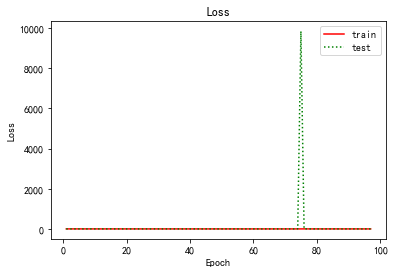

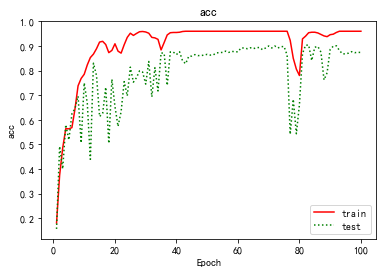

In [27]:
import torch_plot
torch_plot.plot(train_losses[3:], test_losses[3:], dtype='Loss')
torch_plot.plot(train_accs, test_accs)

In [30]:
train_accs

[0.18,
 0.374,
 0.485,
 0.564,
 0.563,
 0.568,
 0.644,
 0.738,
 0.768,
 0.785,
 0.823,
 0.853,
 0.867,
 0.889,
 0.916,
 0.919,
 0.906,
 0.873,
 0.882,
 0.909,
 0.879,
 0.871,
 0.905,
 0.935,
 0.952,
 0.943,
 0.951,
 0.958,
 0.959,
 0.957,
 0.952,
 0.935,
 0.933,
 0.927,
 0.884,
 0.914,
 0.945,
 0.954,
 0.955,
 0.955,
 0.956,
 0.959,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.923,
 0.85,
 0.806,
 0.78,
 0.929,
 0.94,
 0.954,
 0.956,
 0.956,
 0.953,
 0.947,
 0.941,
 0.938,
 0.946,
 0.948,
 0.955,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96]